In [48]:
import mne
import numpy as np
from pathlib import Path 
import matplotlib.pyplot as plt

# sklearn
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, ShuffleSplit, StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

mne.set_log_level('CRITICAL')

numpy_dir = Path('out_data/2023/npy/')


psd: (1240, 32, 41), raw: (1240, 32, 513), indexes: (2, 1240)
(1240, 1)
SVM  Classification score: 0.6763787721123828 (std. 0.20411926045119871)


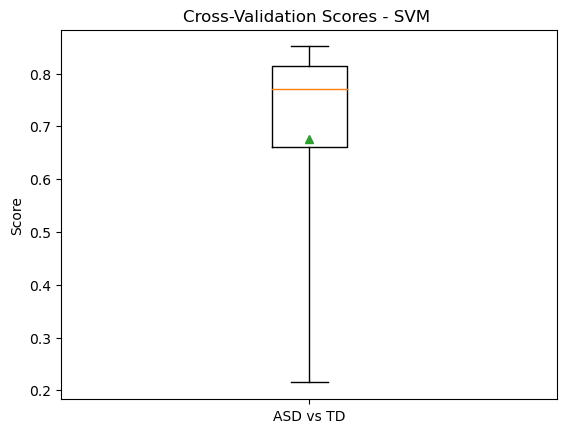

knn  Classification score: 0.5613813735691988 (std. 0.09972891677764247)


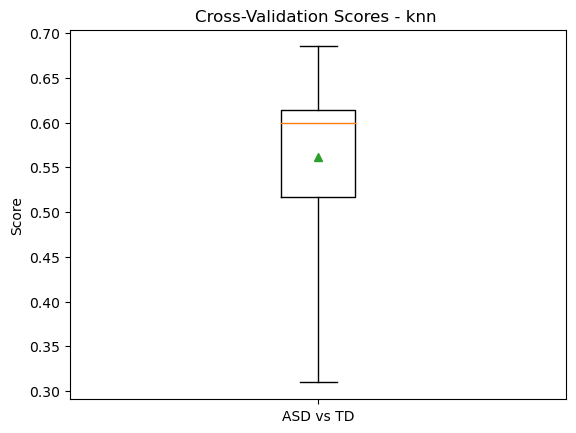

LDA  Classification score: 0.6763787721123828 (std. 0.20411926045119871)


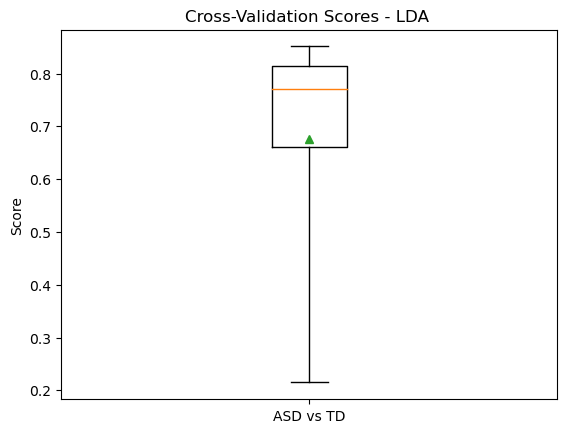

Logistic Regression  Classification score: 0.6763787721123828 (std. 0.20411926045119871)


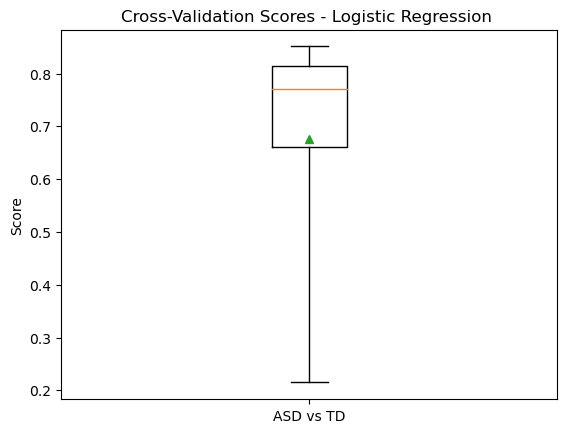

In [102]:
def extractFeature(signal, bands):
    beta = np.mean(signal[10:14])
    delta = np.mean(signal[1:5])
    return [np.mean(signal[x[0]:x[1]]) for x in bands]
    #eturn [beta, delta]

def visualizeResults(scores, title):
    fig, ax = plt.subplots()
    ax.boxplot(scores,
        showmeans=True, # Green triangle marks the mean.
        whis=(0, 100),  # Whiskers span the entire range of the data.
        labels=['ASD vs TD'])
    ax.set_ylabel('Score')
    ax.set_title(f'Cross-Validation Scores - {title}')
    plt.show()

def testModel(X, y, clf, cv, n_jobs, title, scoring=None):
    scores_full = cross_val_score(clf, X, y, cv=cv, n_jobs=1, scoring=scoring)
    print(f"{title} Classification score: {np.mean(scores_full)} (std. {np.std(scores_full)})")
    visualizeResults(scores_full, title)

def getX(epochs, bands, channels=[], channelNames=[]):

    if (len(channelNames) < 1 ): # include all channels
        X_2d = np.empty([epochs.shape[0], epochs.shape[1], len(bands)], dtype=float)
    else: #include specific channels
        X_2d = np.empty([epochs.shape[0], len(channelNames), len(bands)], dtype=float)

    for epoch_id, epoch in enumerate(epochs):
        _ch_count = 0
        for channel_id, channel in enumerate(epoch):

            # If specific channels not defined use all channels
            if not len(channels) and not len(channelNames):
                X_2d[epoch_id, channel_id, :] = extractFeature(channel, bands)
            
            # If we pass through specific channels handle X definition here
            else:
                if channels[channel_id] in channelNames:
                    #print(channels[channel_id], _ch_count)
                    X_2d[epoch_id, _ch_count, :] = extractFeature(channel, bands)
                    _ch_count += 1


    n_trials = epochs.shape[0]
    X_2d_reshaped = X_2d.reshape(n_trials, -1)
    #print(X_2d.shape, "-> ", X_2d_reshaped.shape)
    return X_2d_reshaped

def getY(epochs_index):
    # Encode: ASD = 0, TD = 1.
    y = np.empty(epochs_index.shape[1], dtype=int)
    y[epochs_index[0]] = 0
    y[epochs_index[1]] = 1
    return y

def runTests(X_2d, y, channel=""):
    #cv = ShuffleSplit(10, test_size=0.2, random_state=42)
    n_splits = 10
    scoring = 'roc_auc'
    cv = StratifiedKFold(n_splits=n_splits)

    # SVM
    clf = SVC(C=1, kernel='linear')
    testModel(X_2d, y, clf, cv, 1, f"SVM {channel}", scoring)

    #KNN
    clf = KNeighborsClassifier(n_neighbors=3)
    testModel(X_2d, y, clf, cv, 1, f"knn {channel}", scoring)

    #LDA
    clf = LinearDiscriminantAnalysis()
    testModel(X_2d, y, clf, cv, 1, f"LDA {channel}", scoring)

    
    # Logistic Regression
    clf = make_pipeline(StandardScaler(),
    LogisticRegression(max_iter=500))
    testModel(X_2d, y, clf, cv, 1, f"Logistic Regression {channel}", scoring)

def main():
    epochs_psd = np.load(numpy_dir / 'epochs_psd.npy')
    epochs_raw =  np.load(numpy_dir / 'epochs_raw.npy')
    epochs_index = np.load(numpy_dir / 'epochs_asd_td_index.npy')
    channels = np.load(numpy_dir / 'channels.npy')
    print(f'psd: {epochs_psd.shape}, raw: {epochs_raw.shape}, indexes: {epochs_index.shape}')
    y = getY(epochs_index)
    bands = [[10, 14]]
    x = getX(epochs_psd, bands, channels, ['Pz'])
    #x = getX(epochs_psd, 2)
    print(x.shape)
    runTests(x, y)

    #print(epochs_psd)
main()

In [74]:
array = [[1,2], [3, 4]]
out = [x[0] for x in array]
print(out)

[1, 3]
